In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import signal
%matplotlib inline

##Import Reference Data

In [81]:
df_R = pd.read_csv(filepath_or_buffer = 'data/CompleteCal_shift.csv', parse_dates = [0], index_col = 0)
print df_R[:5]

                     CO_ppm  NO_ppb  NO2_ppb  O3_ppb
Date                                                
2014-07-07 07:13:00     0.2     1.1     13.4      28
2014-07-07 07:14:00     0.3     1.2     13.8      28
2014-07-07 07:15:00     0.3     1.2     14.4      26
2014-07-07 07:16:00     0.3     1.3     14.9      25
2014-07-07 07:17:00     0.3     7.8     17.9      24


##Import Pod Data

In [82]:
df_P = pd.io.parsers.read_csv(filepath_or_buffer = 'data/D0_clean.csv', parse_dates = [0], index_col = 0)
print df_P[:5]

                       UnixTime  e2v03  Temp    Rh
YYYY/MM/DD_HH:MM:SS                               
2014-07-11 00:00:00  1405036800    101  39.5  17.9
2014-07-11 00:00:08  1405036808    101  39.5  17.9
2014-07-11 00:00:17  1405036817    100  39.5  17.9
2014-07-11 00:00:25  1405036825     99  39.5  17.9
2014-07-11 00:00:34  1405036834     98  39.5  17.9


###Resample all of the data, so that the reference, pod, and solar data are in the same dataframe, and also average over a specified time.

In [83]:
resamp_time = '1Min'

In [84]:
df_all = pd.concat([df_R.O3_ppb.resample(resamp_time), df_P.resample(resamp_time)], axis=1).dropna()
print df_all[:5]

                     O3_ppb      UnixTime      e2v03       Temp         Rh
Date                                                                      
2014-07-11 00:20:00      43  1.405038e+09  87.000000  38.828571  17.614286
2014-07-11 00:21:00      42  1.405038e+09  85.571429  38.800000  17.600000
2014-07-11 00:22:00      41  1.405038e+09  85.666667  38.783333  17.616667
2014-07-11 00:23:00      38  1.405038e+09  87.285714  38.728571  17.785714
2014-07-11 00:24:00      40  1.405038e+09  89.142857  38.700000  17.814286


####Create 'days since start' feature.

In [85]:
df_all['days from start'] = df_all['UnixTime']
for i in range(0,len(df_all['UnixTime'])):
    df_all['days from start'][i] = int(df_all['UnixTime'][i]- df_all['UnixTime'][0])/86400

####Drop the names from all of the data to prepare it for filtering

In [86]:
df_fit = df_all.dropna()

In [87]:
rh_sm = None
temp_sm = None
ref_o3_sm = None
pod_o3_sm = None

#Declare the data column to filter.

#Filtering

####Define functions to plot the raw and filtered data

In [88]:
def plot_data(data, title):
    fig = plt.figure(figsize = (15,15))
    ax = fig.add_subplot(111)
    ax.plot(data, marker = '.')
    ax.set_title(title)

####Define a function that filters the data.

In [89]:
def plot_filter(b):
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    ax2 = ax1.twinx()

    w, h = signal.freqz(b)
    w /= np.pi
    ax1.plot(w, 20 * np.log10(abs(h)), 'r-')
    ax2.plot(w[1:], -np.diff(np.unwrap(np.angle(h))), 'b-')
    ax2.set_ylim(bottom=0.)

    ax3 = fig.add_subplot(212)
    ax3.plot(w, 20 * abs(h), 'r-')

In [90]:
def hanning_window_fir_filtering(data_points, filter_minutes, y_data):
    #make a window (finite-impulse response method), 
    #second agrment is frequency in units where 1 is sampling frequency (1 means 1 cycle per minute, 0.2 is equal to a period of 5 minutes) 
    #first agrument is how many data points are in the window (frequency resolution) if you choose 100, there is a time delay by 50 data points
    samp_freq = 1.0/filter_minutes
    b = signal.firwin(data_points, samp_freq, window='hanning')
    
    impulse = np.zeros((100,))
    impulse[0] = 1.

    #replace impulse with my y values
    y = signal.lfilter(b, 1., y_data)
    
    #call the plotting functions for the filtered and raw data.
    plot_data(y_data,'Raw Data')
    plot_data(y,'Filtered Data')    
    
    #Call the impulse plotting function
    plot_filter(b)
    
    #Delete the shifted points from the new data
    y_final = np.delete(y, list(xrange(data_points)))
    
    return y_final

####Call the filtering function

Reference Data
[ 47.50858903  47.8883803   47.35206001  45.55228784  43.16510913
  40.71846572  37.9022871   35.32089874  35.21834796  38.46181178
  42.25160516  43.26175665  41.99052097  41.29593153  41.44958533
  40.05227269  37.00405125  35.84279066  38.50891351  41.77519043
  41.48265709  38.39011168  36.81477869  38.4823605   40.97259397]


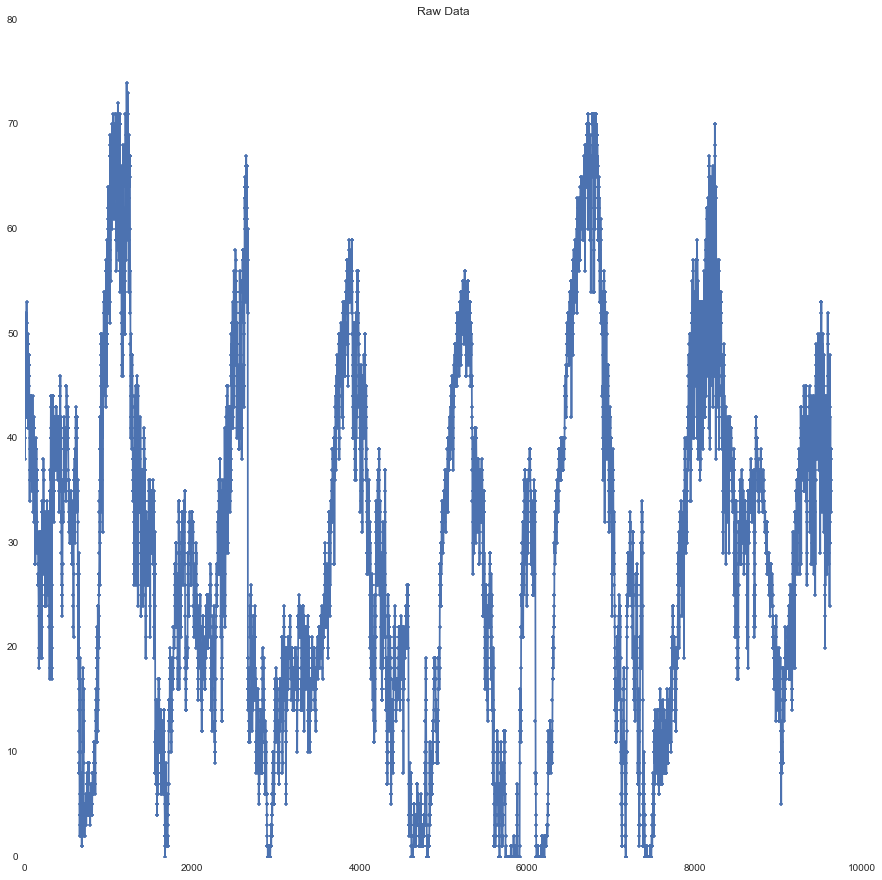

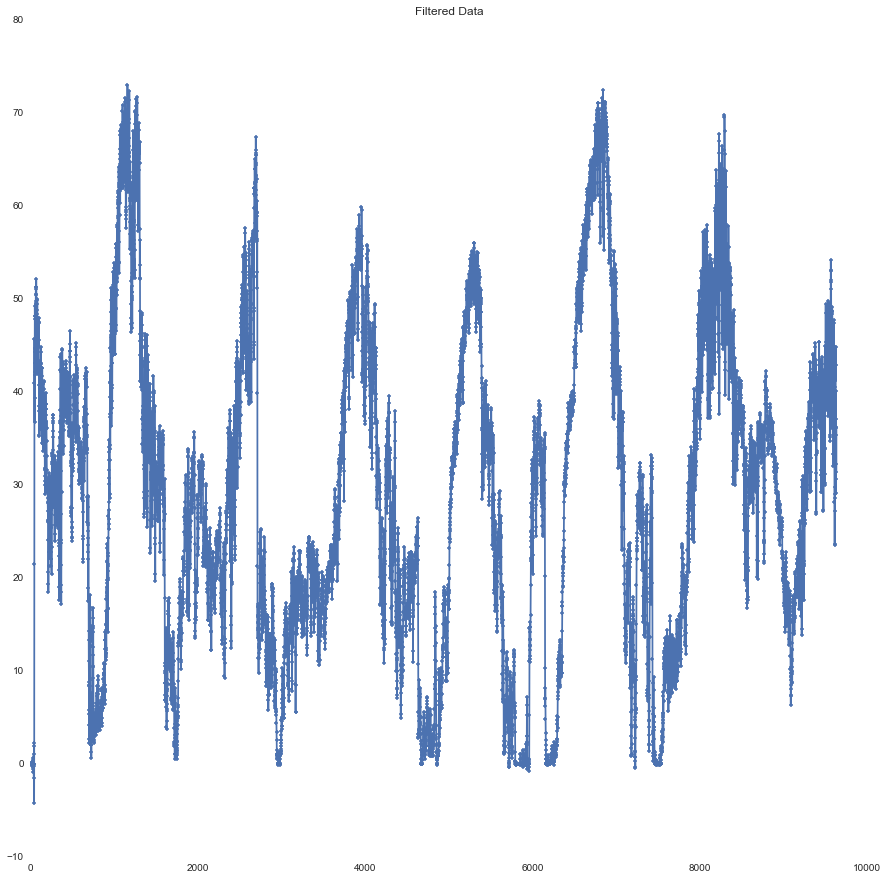

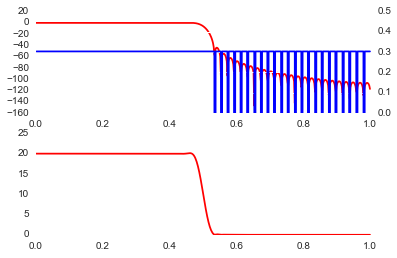

In [92]:
#Choose the number of data points in the window, and the number of minutes in the sampling period.
data_points = 100
filter_minutes = 2

ref_o3_sm = hanning_window_fir_filtering(data_points, filter_minutes, df_fit['O3_ppb'].values)
print 'Reference Data'
print ref_o3_sm[:25]

#pod_o3_sm = hanning_window_fir_filtering(data_points, filter_minutes, df_fit['e2v03'].values)
#print 'Pod Data'
#print pod_o3_sm[:5]

####Make a new dataframe without the offset rows, and append the new data into it.

In [93]:
df_short = df_fit.ix[data_points:]
print df_short[:5]

                     O3_ppb      UnixTime       e2v03       Temp         Rh  \
Date                                                                          
2014-07-11 02:04:00      36  1.405044e+09  105.142857  36.957143  19.342857   
2014-07-11 02:05:00      35  1.405044e+09  101.142857  36.900000  19.100000   
2014-07-11 02:06:00      35  1.405044e+09   97.714286  36.900000  19.171429   
2014-07-11 02:07:00      35  1.405044e+09   95.333333  36.866667  19.083333   
2014-07-11 02:08:00      33  1.405045e+09   92.000000  36.842857  19.000000   

                     days from start  
Date                                  
2014-07-11 02:04:00                0  
2014-07-11 02:05:00                0  
2014-07-11 02:06:00                0  
2014-07-11 02:07:00                0  
2014-07-11 02:08:00                0  


In [94]:
df_short['ref_o3_smooth'] = ref_o3_sm
#df_short['pod_o3_smooth'] = pod_o3_sm
print df_short[:25]

                     O3_ppb      UnixTime       e2v03       Temp         Rh  \
Date                                                                          
2014-07-11 02:04:00      36  1.405044e+09  105.142857  36.957143  19.342857   
2014-07-11 02:05:00      35  1.405044e+09  101.142857  36.900000  19.100000   
2014-07-11 02:06:00      35  1.405044e+09   97.714286  36.900000  19.171429   
2014-07-11 02:07:00      35  1.405044e+09   95.333333  36.866667  19.083333   
2014-07-11 02:08:00      33  1.405045e+09   92.000000  36.842857  19.000000   
2014-07-11 02:09:00      35  1.405045e+09   92.285714  36.800000  19.171429   
2014-07-11 02:10:00      39  1.405045e+09   94.285714  36.800000  19.328571   
2014-07-11 02:11:00      41  1.405045e+09   94.000000  36.742857  19.328571   
2014-07-11 02:12:00      40  1.405045e+09   92.285714  36.700000  19.300000   
2014-07-11 02:13:00      41  1.405045e+09   91.000000  36.700000  19.400000   
2014-07-11 02:14:00      41  1.405045e+09   91.28571

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


##Make a csv file with the smoothed data

In [95]:
df_short.to_csv(path_or_buf = 'data/D0_filt_all.csv')